In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 32
learning_rate  = 1e-2
momentum = 0.5
epochs = 100

In [3]:
train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transforms.Compose([
                                transforms.Resize([256, 256]),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),                       # 数据类型转化
                                transforms.Normalize(
                                    (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # 数据归一化处理
                            ]))

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                           ]))

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

In [6]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels, **kwargs),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        out = self.feature(x)
        return out

In [7]:
class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = BasicConv2d(in_channels=inplanes,
                                      out_channels=squeeze_planes, kernel_size=1)
        self.expand1x1 = BasicConv2d(in_channels=squeeze_planes, out_channels=expand1x1_planes,
                                        kernel_size=1)
        self.expand3x3 = BasicConv2d(in_channels=squeeze_planes, out_channels=expand3x3_planes,
                                        kernel_size=3, padding=1)

    def forward(self, x):
        x = self.squeeze(x)
        return torch.cat([
            self.expand1x1(x),
            self.expand3x3(x)
        ], dim=1)

In [8]:
class SqueezeNet(nn.Module):

    def __init__(self, version=1.0, num_classes=10):
        super(SqueezeNet, self).__init__()
        if version not in [1.0, 1.1]:
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1.0 or 1.1 expected".format(version=version))
        self.num_classes = num_classes
        if version == 1.0:
            self.features = nn.Sequential(
                BasicConv2d(in_channels=3, out_channels=96,
                          kernel_size=7, stride=2),
                nn.MaxPool2d(kernel_size=3, stride=2),
                Fire(inplanes=96, squeeze_planes=16,
                     expand1x1_planes=64, expand3x3_planes=64),
                Fire(inplanes=128, squeeze_planes=16,
                     expand1x1_planes=64, expand3x3_planes=64),
                Fire(inplanes=128, squeeze_planes=32,
                     expand1x1_planes=128, expand3x3_planes=128),
                nn.MaxPool2d(kernel_size=3, stride=2),
                Fire(inplanes=256, squeeze_planes=32,
                     expand1x1_planes=128, expand3x3_planes=128),
                Fire(inplanes=256, squeeze_planes=48,
                     expand1x1_planes=192, expand3x3_planes=192),
                Fire(inplanes=384, squeeze_planes=48,
                     expand1x1_planes=192, expand3x3_planes=192),
                Fire(inplanes=384, squeeze_planes=64,
                     expand1x1_planes=256, expand3x3_planes=256),
                nn.MaxPool2d(kernel_size=3, stride=2),
                Fire(inplanes=512, squeeze_planes=64,
                     expand1x1_planes=256, expand3x3_planes=256),
            )
        else:
            self.features = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=64,
                          kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                Fire(inplanes=64, squeeze_planes=16,
                     expand1x1_planes=64, expand3x3_planes=64),
                Fire(inplanes=128, squeeze_planes=16,
                     expand1x1_planes=64, expand3x3_planes=64),
                nn.MaxPool2d(kernel_size=3, stride=2),
                Fire(inplanes=128, squeeze_planes=32,
                     expand1x1_planes=128, expand3x3_planes=128),
                Fire(inplanes=256, squeeze_planes=32,
                     expand1x1_planes=128, expand3x3_planes=128),
                nn.MaxPool2d(kernel_size=3, stride=2),
                Fire(inplanes=256, squeeze_planes=48,
                     expand1x1_planes=192, expand3x3_planes=192),
                Fire(inplanes=384, squeeze_planes=48,
                     expand1x1_planes=192, expand3x3_planes=192),
                Fire(inplanes=384, squeeze_planes=64,
                     expand1x1_planes=256, expand3x3_planes=256),
                Fire(inplanes=512, squeeze_planes=64,
                     expand1x1_planes=256, expand3x3_planes=256),
            )
        # Final convolution is initialized differently form the rest
        final_conv = BasicConv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [9]:
net = SqueezeNet(version=1.0).to(DEVICE)
# net = models.squeezenet1_0().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.5)

In [10]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()
        
        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    train_loss /= len(val_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [11]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('\nVAL set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))
    
    return val_loss, val_acc

In [12]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [13]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [14]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')

    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)

    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [15]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.334576
Train Epoch: 1 [3200/40000 (8%)]	Loss: 2.050971
Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.075827
Train Epoch: 1 [9600/40000 (24%)]	Loss: 1.944542
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.822016
Train Epoch: 1 [16000/40000 (40%)]	Loss: 2.001810
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.789978
Train Epoch: 1 [22400/40000 (56%)]	Loss: 1.830769
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.801955
Train Epoch: 1 [28800/40000 (72%)]	Loss: 1.872733
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.703428
Train Epoch: 1 [35200/40000 (88%)]	Loss: 1.578493
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.701436

VAL set: Average loss: 0.0518, Accuracy: 4292.0/10000 (42.9%)

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.433554
Train Epoch: 2 [3200/40000 (8%)]	Loss: 1.479400
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.515968
Train Epoch: 2 [9600/40000 (24%)]	Loss: 1.401816
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.477996
Train Epoch: 2 [16000/40000 (40%)]	Loss: 1.558765
Trai

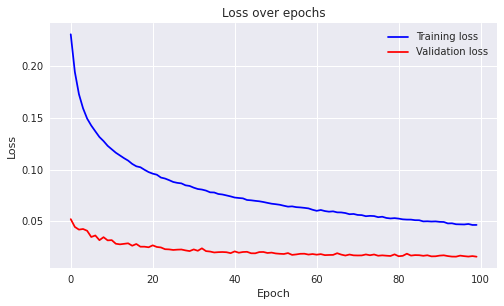

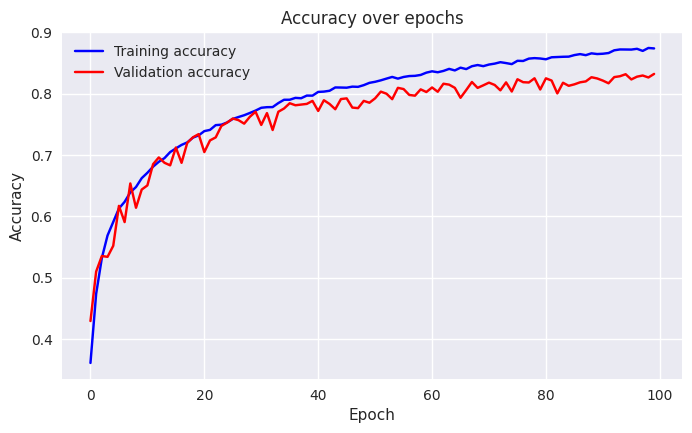

In [16]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'SqueezeNet - predictions')

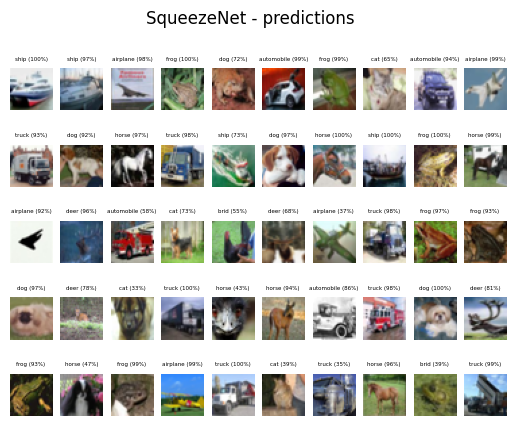

In [17]:
CIFAR_dict = {0: 'airplane',
              1: 'automobile',
              2: 'brid',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[int(torch.argmax(probs))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('SqueezeNet - predictions')

In [ ]:
"""
SqueezeNet
Mine(batch_size = 32):
After 020 Epoch: 73.4%
After 040 Epoch: 78.8%
After 060 Epoch: 80.3%
After 080 Epoch: 80.7%
After 100 Epoch: 83.2%
structure:
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 512, 12, 12]         --
|    └─BasicConv2d: 2-1                  [-1, 96, 109, 109]        --
|    |    └─Sequential: 3-1              [-1, 96, 109, 109]        14,400
|    └─MaxPool2d: 2-2                    [-1, 96, 54, 54]          --
|    └─Fire: 2-3                         [-1, 128, 54, 54]         --
|    |    └─BasicConv2d: 3-2             [-1, 16, 54, 54]          1,584
|    |    └─BasicConv2d: 3-3             [-1, 64, 54, 54]          1,216
|    |    └─BasicConv2d: 3-4             [-1, 64, 54, 54]          9,408
|    └─Fire: 2-4                         [-1, 128, 54, 54]         --
|    |    └─BasicConv2d: 3-5             [-1, 16, 54, 54]          2,096
|    |    └─BasicConv2d: 3-6             [-1, 64, 54, 54]          1,216
|    |    └─BasicConv2d: 3-7             [-1, 64, 54, 54]          9,408
|    └─Fire: 2-5                         [-1, 256, 54, 54]         --
|    |    └─BasicConv2d: 3-8             [-1, 32, 54, 54]          4,192
|    |    └─BasicConv2d: 3-9             [-1, 128, 54, 54]         4,480
|    |    └─BasicConv2d: 3-10            [-1, 128, 54, 54]         37,248
|    └─MaxPool2d: 2-6                    [-1, 256, 26, 26]         --
|    └─Fire: 2-7                         [-1, 256, 26, 26]         --
|    |    └─BasicConv2d: 3-11            [-1, 32, 26, 26]          8,288
|    |    └─BasicConv2d: 3-12            [-1, 128, 26, 26]         4,480
|    |    └─BasicConv2d: 3-13            [-1, 128, 26, 26]         37,248
|    └─Fire: 2-8                         [-1, 384, 26, 26]         --
|    |    └─BasicConv2d: 3-14            [-1, 48, 26, 26]          12,432
|    |    └─BasicConv2d: 3-15            [-1, 192, 26, 26]         9,792
|    |    └─BasicConv2d: 3-16            [-1, 192, 26, 26]         83,520
|    └─Fire: 2-9                         [-1, 384, 26, 26]         --
|    |    └─BasicConv2d: 3-17            [-1, 48, 26, 26]          18,576
|    |    └─BasicConv2d: 3-18            [-1, 192, 26, 26]         9,792
|    |    └─BasicConv2d: 3-19            [-1, 192, 26, 26]         83,520
|    └─Fire: 2-10                        [-1, 512, 26, 26]         --
|    |    └─BasicConv2d: 3-20            [-1, 64, 26, 26]          24,768
|    |    └─BasicConv2d: 3-21            [-1, 256, 26, 26]         17,152
|    |    └─BasicConv2d: 3-22            [-1, 256, 26, 26]         148,224
|    └─MaxPool2d: 2-11                   [-1, 512, 12, 12]         --
|    └─Fire: 2-12                        [-1, 512, 12, 12]         --
|    |    └─BasicConv2d: 3-23            [-1, 64, 12, 12]          32,960
|    |    └─BasicConv2d: 3-24            [-1, 256, 12, 12]         17,152
|    |    └─BasicConv2d: 3-25            [-1, 256, 12, 12]         148,224
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Dropout: 2-13                     [-1, 512, 12, 12]         --
|    └─BasicConv2d: 2-14                 [-1, 10, 12, 12]          --
|    |    └─Sequential: 3-26             [-1, 10, 12, 12]          5,150
|    └─AdaptiveAvgPool2d: 2-15           [-1, 10, 1, 1]            --
|    └─Flatten: 2-16                     [-1, 10]                  --
==========================================================================================
Total params: 746,526
Trainable params: 746,526
Non-trainable params: 0
Total mult-adds (M): 171.34
==========================================================================================
Input size (MB): 0.57
Forward/backward pass size (MB): 17.43
Params size (MB): 2.85
Estimated Total Size (MB): 20.85
==========================================================================================
parameters_count: 746526

"""